### Data Exploration and Fitting of First and Second Level Models

Iowa Gambling Task data exploration and subsequent fitting of FLM and SLM of six participants on the contrast between wins and losses. 

#### Import Packages

In [7]:
# Import packages
import os
import matplotlib.pyplot as plt
import numpy as np
import inspect
import pandas as pd
import pickle
from scipy.stats import norm
import seaborn as sns

from nilearn import image
from nilearn import plotting
from nilearn.glm.first_level import first_level_from_bids
from nilearn.plotting import plot_design_matrix, plot_contrast_matrix, plot_stat_map
from nilearn.image import mean_img, get_data, math_img
from nilearn.reporting import make_glm_report, get_clusters_table
from nilearn.glm import threshold_stats_img
from nilearn.glm.second_level import SecondLevelModel, non_parametric_inference

from atlasreader import create_output
from IPython.display import display, HTML, Image
import glob
import warnings
warnings.filterwarnings('ignore')

#### Load in BIDS data

Set space label and slice time refrence, inspect default arguments and data shapes

In [2]:
# Path to data and derivatives folders
data_dir='/work/fMRI_data/BIDS_2024E/' 
derivatives_dir= '/work/fMRI_data/BIDS_2024E/derivatives/'

In [3]:
# First Level Models from BIDS
task_label = 'boldiowa'
space_label ='MNI152NLin2009cAsym'

models, models_run_imgs, models_events, models_confounds = first_level_from_bids(
    dataset_path = data_dir, 
    task_label = task_label, 
    space_label = space_label,
    derivatives_folder=derivatives_dir, 
    n_jobs=-2, 
    slice_time_ref = 0.462,
    verbose=False,
    img_filters=[("desc", "preproc")])

print(models[0:])

[FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0139', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0136', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0142', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0141', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0138', t_r=1,
                verbose=False), FirstLevelModel(n_jobs=-2, slice_time_ref=0.462, subject_label='0140', t_r=1,
                verbose=False)]


In [4]:
# FLM default arguments
args=inspect.getfullargspec(first_level_from_bids)
df = pd.DataFrame(args.defaults,args.args[2:])
print(df)

                                        0
space_label                          None
sub_labels                           None
img_filters                          None
t_r                                  None
slice_time_ref                        0.0
hrf_model                          glover
drift_model                        cosine
high_pass                            0.01
drift_order                             1
fir_delays                            [0]
min_onset                             -24
mask_img                             None
target_affine                        None
target_shape                         None
smoothing_fwhm                       None
memory              Memory(location=None)
memory_level                            1
standardize                         False
signal_scaling                          0
noise_model                           ar1
verbose                                 0
n_jobs                                  1
minimize_memory                   

In [5]:
# fMRI dimensions
func01=([os.path.basename(run) for run in models_run_imgs[0]])
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
func_img = image.load_img(func01_path)
func_hdr = func_img.header

In [6]:
print(f"Shape of fMRI {func_img.shape}")
print(f"Voxel dimensions and sampling rate {func_hdr.get_zooms()}")
print(f"Units {func_hdr.get_xyzt_units()}")

Shape of fMRI (78, 92, 78, 2400)
Voxel dimensions and sampling rate (np.float32(2.526), np.float32(2.526), np.float32(2.5), np.float32(1.0))
Units ('mm', 'sec')


#### Subset Confounds and Events 

Extract Firston24 and global signal confounds, and the relevant events columns, (trial_type, onset and duration as well as ID and run). A visualization of the distribution of wins, losses and neutral trials is also made. 

In [7]:
# Subset selected confounds (Friston24 and Global Signal)
confound_friston24_GSR = [
    'global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2',
    'trans_x','trans_y','trans_z',
    'rot_x','rot_y','rot_z',
    'trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
    'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1',
    'trans_x_power2','trans_y_power2','trans_z_power2',
    'rot_x_power2','rot_y_power2','rot_z_power2']

for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_friston24_GSR]
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1
print(models_confounds[0][0].columns)

Index(['global_signal', 'global_signal_derivative1', 'global_signal_power2',
       'global_signal_derivative1_power2', 'trans_x', 'trans_y', 'trans_z',
       'rot_x', 'rot_y', 'rot_z', 'trans_x_derivative1', 'trans_y_derivative1',
       'trans_z_derivative1', 'rot_x_derivative1', 'rot_y_derivative1',
       'rot_z_derivative1', 'trans_x_power2', 'trans_y_power2',
       'trans_z_power2', 'rot_x_power2', 'rot_y_power2', 'rot_z_power2'],
      dtype='object')


In [8]:
# View all logged event names
print(models_events[0][0].columns)

Index(['onset', 'duration', 'win', 'loss', 'total', 'trial_type', 'response',
       'n_moves', 'RT', 'run', 'ID', 'task'],
      dtype='object')


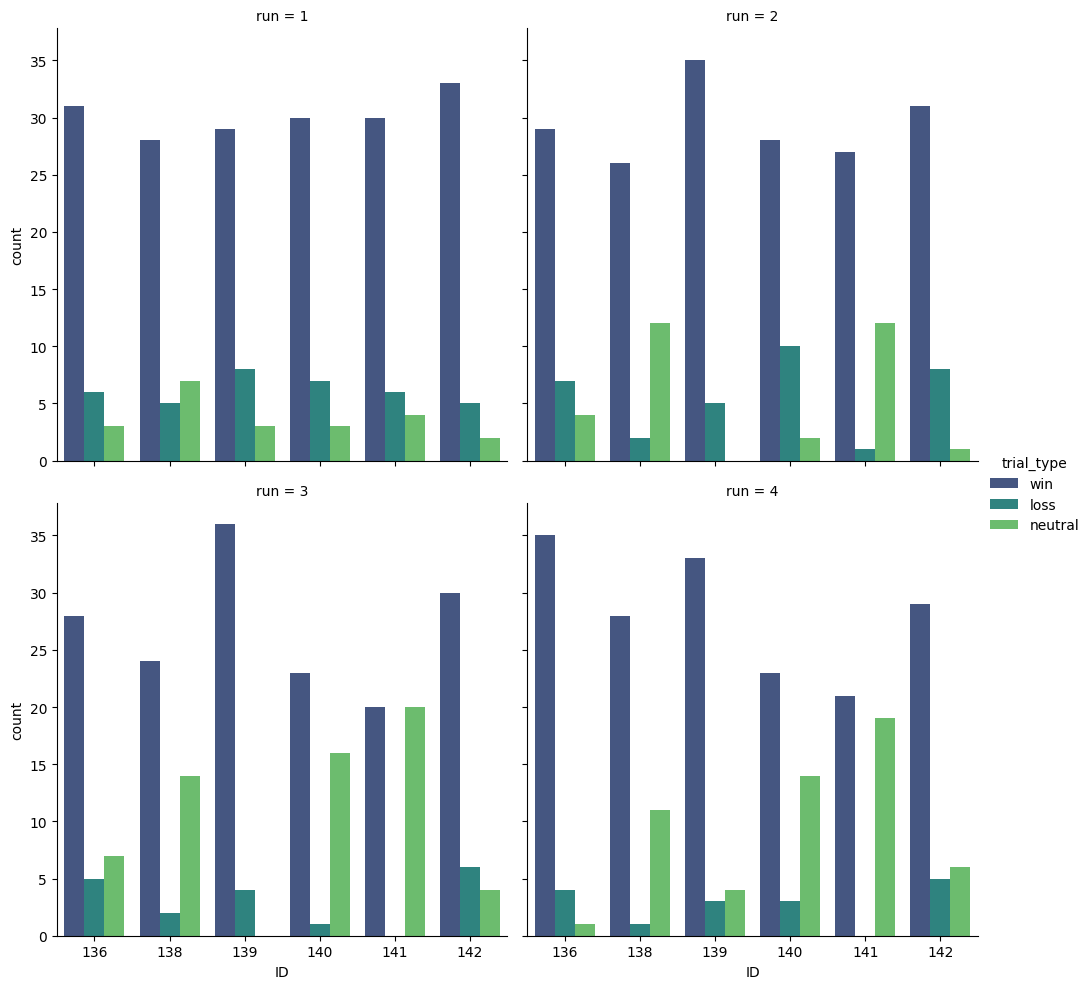

In [10]:
# Overview of wins, losses and neutrals for all runs and all participants
event_df = pd.DataFrame(columns=list(models_events[0][0].columns))
for i in range(len(models_events)):
    for j in range(len(models_events[i])):
        event_df = pd.concat([event_df, models_events[i][j]])
event_df = event_df[['ID', 'run', 'trial_type']].value_counts().reset_index().rename(columns = {"index": "value", 0: "count"})
event_df = event_df[event_df['trial_type'] != 'decks']

# Visualising trial type distribution (40 trials per run)
fig = sns.catplot(data=event_df, x="ID", y="count", hue="trial_type", 
                  kind="bar", errorbar = None, col = 'run', col_wrap = 2, 
                  palette = 'viridis')
fig.savefig("../out/outcomes_per_run.png") 

In [11]:
# To avoid problems with runs where participants have no losses, neutral are counted as losses 
for sub in range(len(models_events)):
    for run in range(len(models_events[sub])):
        models_events[sub][run].loc[models_events[sub][run]['trial_type'] == 'neutral', 'trial_type'] = 'loss'

In [12]:
# Subset relevant events 
events_sub= ['onset','duration', 'trial_type']

# Subset confounds with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
    models_events[ii][:]=events1

#### Fit Fist Level Models and Plot

The FLM are all six fitted to the contrast win-loss, and the files are then saved to the 'out' folder. 

An example of a design matrix is also plotted as well as the results of the FLM, (p = 0.001)

In [13]:
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)

for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    print(model.subject_label)
    
    model.fit(imgs, events, confounds)
    model.zmap = model.compute_contrast('win-loss')
f = open('../out/all_flm_IGT.pkl', 'wb')
pickle.dump([models, models_run_imgs, models_events, models_confounds], f)
f.close()

0139
0136
0142
0141
0138
0140


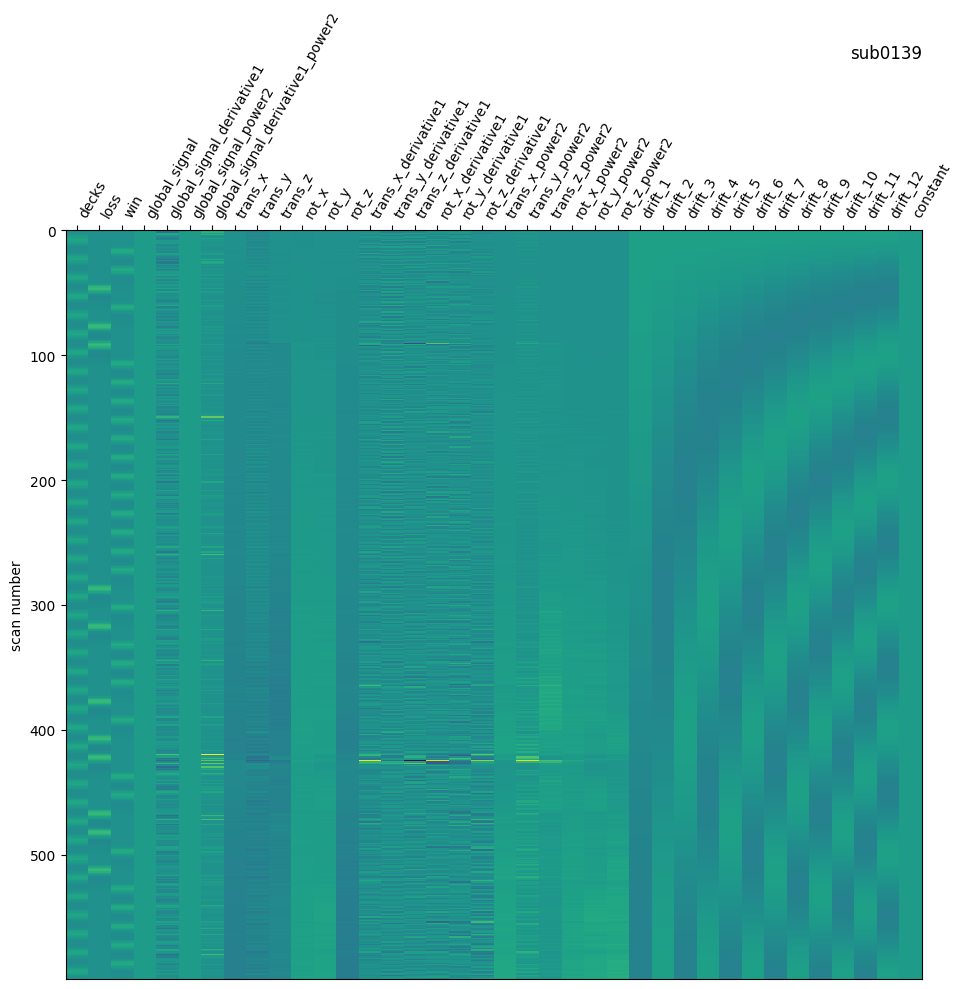

In [35]:
# Plot example of design matrix 
design_matrix = models[0].design_matrices_[0]
dm = plot_design_matrix(design_matrix)
plt.title(f"sub{models[0].subject_label}", loc = "right", x = 1, y = 1.6)
plt.savefig(f"../out/uni_design_matrix_sub{models[0].subject_label}.png")

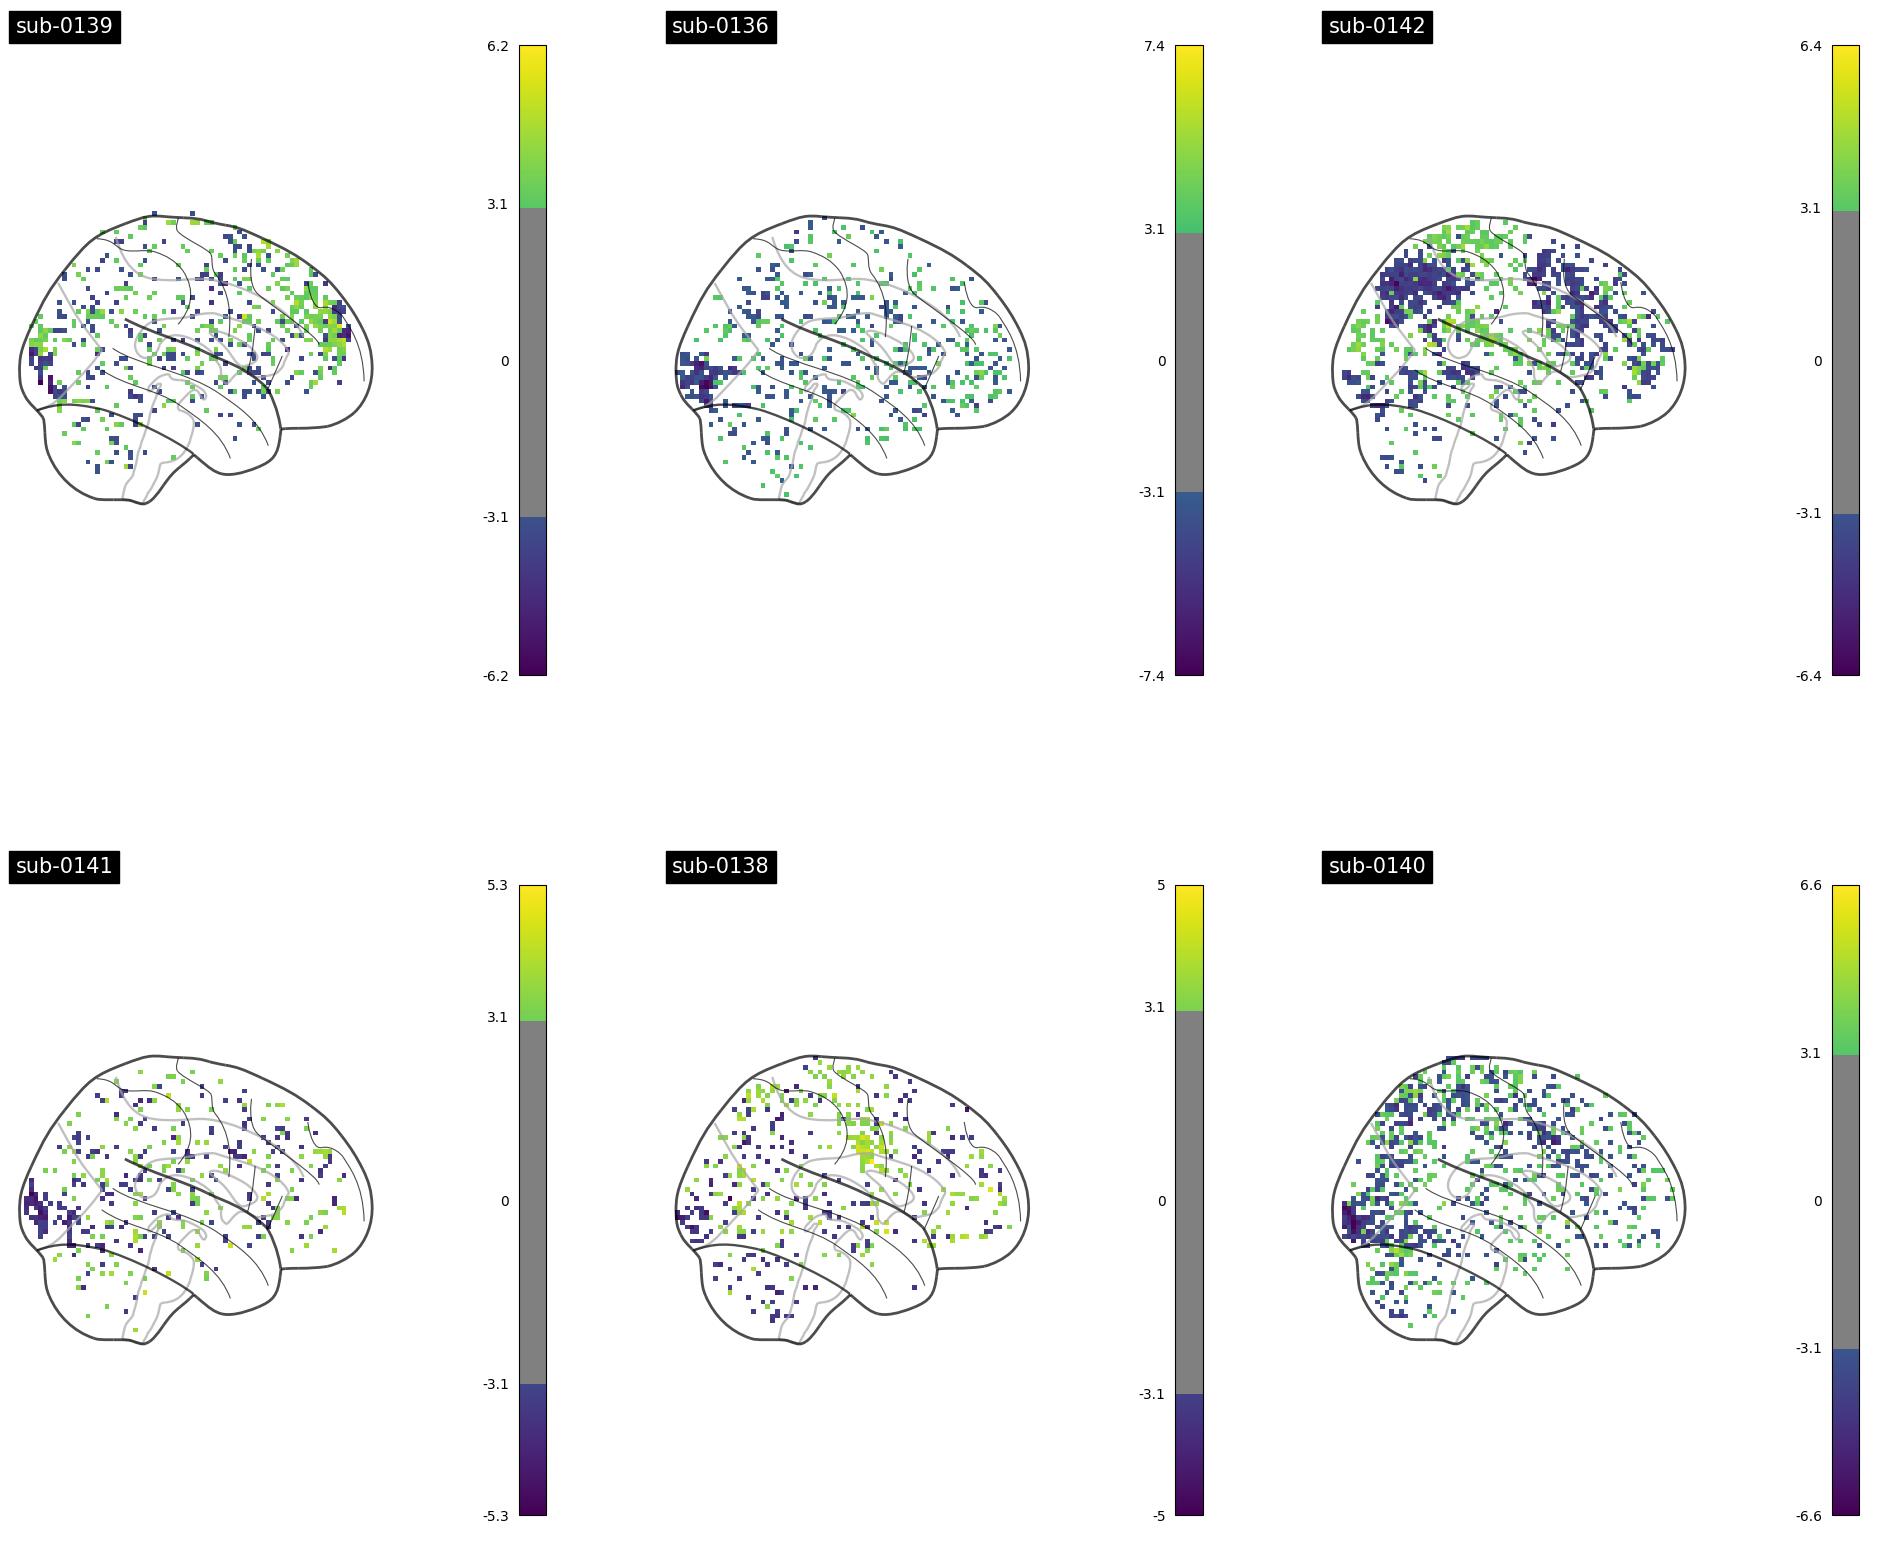

In [37]:
# Plot results 
p001_unc = norm.isf(0.001)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 20)) 
for m_idx, model in enumerate(models):
    plotting.plot_glass_brain(model.zmap, 
                              cmap='viridis',colorbar=True, 
                              threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(m_idx / 3), int(m_idx % 3)],
                              plot_abs=False, display_mode='x')
plt.savefig("../out/FLM_results.png")

#### Second Level Model

Fit the second level model and ploting the results. 

A FDR testt to correct for multiple comparisons is conducted 

In [3]:
## Load models 
f = open("../out/all_flm_IGT.pkl", 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()

In [4]:
#Fit SLM and compute contrast
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(models)
zmap_g = second_level_model.compute_contrast(first_level_contrast='win-loss')

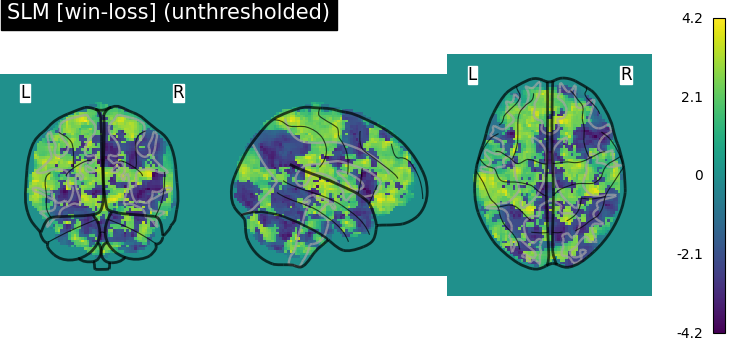

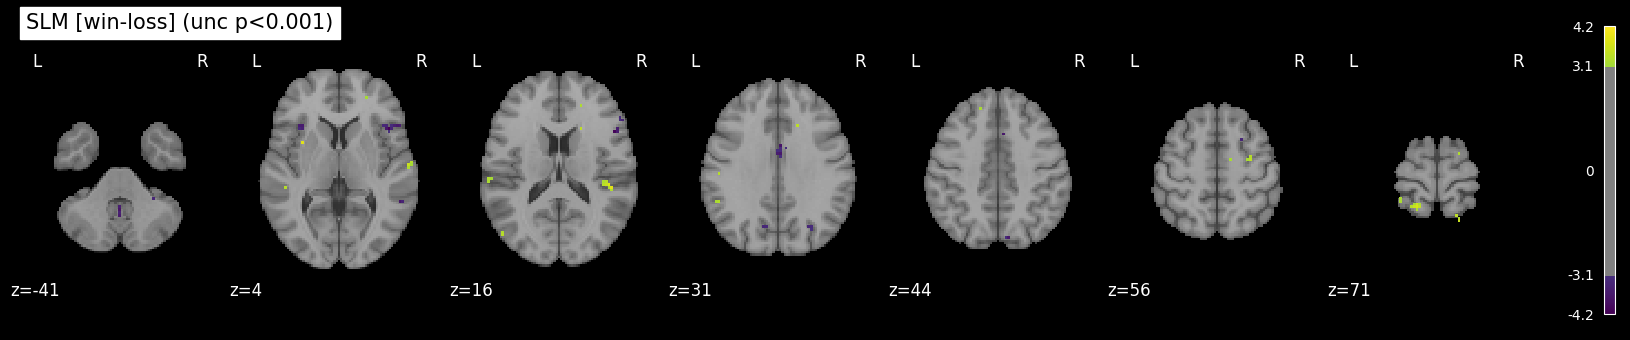

   Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0           1 -15.667999 -51.667999  69.0   4.091830                319
1           2  12.118001  31.690001  -6.0   3.983211                382
2           3  47.482001 -33.985999  19.0   3.916905                382
3          3a  37.378001 -36.511999  19.0   3.514051                   
4           4 -63.662000 -21.355999  11.5   3.834754                127
5           5  17.170001 -61.771999  69.0   3.665779                143
6           6 -53.558000 -26.407999   6.5   3.631610                127
7           7 -10.615999  39.268002  49.0   3.598802                127
8           8 -33.349999 -44.089999  69.0   3.548575                 95
9           9 -30.823999 -13.777999   9.0   3.542998                 95
10         10 -15.667999  44.320002  -6.0   3.515526                 79
11         11  27.274001  -8.725999  66.5   3.308934                 79
12         12 -63.662000 -28.933999  19.0   3.262178            

In [8]:
# plot the group contrasts uncorrected [win-loss]
plotting.plot_glass_brain(zmap_g, cmap='viridis', colorbar=True, 
                          threshold=None,plot_abs=False, title='SLM [win-loss] (unthresholded)', 
                          output_file = "../out/SLM_results.png")
display(Image(filename="../out/SLM_results.png"))
# plot group contrasts uncorrected (p<0.001)
p001_unc = norm.isf(0.001)
plot_stat_map(zmap_g, cmap='viridis', threshold=p001_unc, display_mode='z',  black_bg=True, title='SLM [win-loss] (unc p<0.001)')
plt.show()
table = get_clusters_table(zmap_g, stat_threshold=p001_unc, cluster_threshold=5, two_sided = True)
print(table)

In [42]:
# AtlasReader is used to investigate the areas shown active in the uncorrected (p<0.001) results
outdir = '../out/atlasreader/'
file_name = outdir + "stat_img.nii.gz"
zmap_g.to_filename(file_name)
create_output(zmap_g, voxel_thresh=p001_unc, cluster_extent=5,outdir=outdir,min_distance = 8)
peaks=pd.read_csv(outdir+'atlasreader_peaks.csv')
display(peaks)
clusters=pd.read_csv(outdir+'atlasreader_clusters.csv')
display(clusters)

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,42.430001,21.586001,1.5,0.000000,542.357483,Insula_R,Unknown,65.0% Right_Frontal_Operculum_Cortex; 10.0% Ri...
1,2.0,12.118001,-74.401999,39.0,-3.429100,430.695648,Cuneus_R,Unknown,29.0% Right_Precuneous_Cortex; 28.0% Right_Cun...
2,3.0,42.430001,-33.985999,19.0,3.491254,382.840576,Rolandic_Oper_R,Unknown,43.0% Right_Parietal_Operculum_Cortex; 22.0% R...
3,4.0,12.118001,31.690001,-6.0,3.983211,382.840576,no_label,Right-Cerebral-White-Matter,0% no_label
4,5.0,27.274001,-69.349999,29.0,-3.361971,319.033813,Occipital_Sup_R,Right-Cerebral-White-Matter,37.0% Right_Lateral_Occipital_Cortex_superior_...
5,6.0,-15.667999,-51.667999,69.0,4.091829,319.033813,Precuneus_L,Unknown,49.0% Left_Superior_Parietal_Lobule; 11.0% Lef...
6,7.0,-0.511999,-1.147999,31.5,-3.130104,207.371979,Cingulate_Mid_L,Unknown,88.0% Left_Cingulate_Gyrus_anterior_division
7,8.0,-35.875999,21.586001,1.5,-4.048879,191.420288,Insula_L,Unknown,38.0% Left_Insular_Cortex; 31.0% Left_Frontal_...
8,9.0,17.170001,-61.771999,69.0,3.665779,143.565216,Parietal_Sup_R,Unknown,47.0% Right_Lateral_Occipital_Cortex_superior_...
9,10.0,50.008001,16.534001,16.5,-4.138243,127.613525,Frontal_Inf_Oper_R,ctx-rh-parsopercularis,34.0% Right_Inferior_Frontal_Gyrus_pars_opercu...


,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,44.956001,19.060001,4.0,-3.423543,542.357483,50.00% Insula_R; 47.06% Frontal_Inf_Tri_R,41.18% ctx-rh-parsopercularis; 38.24% Unknown;...,29.41% Right_Frontal_Operculum_Cortex; 29.41% ...
1,2.0,9.592001,-79.454000,44.0,-3.272039,430.695648,66.67% Cuneus_R; 33.33% Precuneus_R,70.37% Unknown; 25.93% ctx-rh-precuneus,85.19% Right_Precuneous_Cortex; 7.41% Right_Cu...
2,3.0,47.482001,-33.985999,19.0,3.453995,382.840576,45.83% Rolandic_Oper_R; 33.33% Temporal_Sup_R;...,41.67% Unknown; 25.00% ctx-rh-supramarginal; 2...,54.17% Right_Parietal_Operculum_Cortex; 45.83%...
3,4.0,12.118001,31.690001,-6.0,3.421931,382.840576,58.33% no_label; 41.67% Cingulate_Ant_R,70.83% Right-Cerebral-White-Matter; 16.67% Unk...,33.33% Right_Cingulate_Gyrus_anterior_division...
4,5.0,27.274001,-69.349999,26.5,-3.260241,319.033813,55.00% Occipital_Mid_R; 45.00% Occipital_Sup_R,35.00% Unknown; 35.00% Right-Cerebral-White-Ma...,100.00% Right_Lateral_Occipital_Cortex_superio...
5,6.0,-15.667999,-51.667999,69.0,3.452541,319.033813,80.00% Parietal_Sup_L; 20.00% Precuneus_L,55.00% Unknown; 40.00% ctx-lh-superiorparietal...,85.00% Left_Superior_Parietal_Lobule; 15.00% L...
6,7.0,-3.037999,-3.673999,29.0,-3.359260,207.371979,53.85% Cingulate_Mid_R; 30.77% no_label; 15.38...,92.31% Unknown; 7.69% ctx-lh-unknown,61.54% Right_Cingulate_Gyrus_anterior_division...
7,8.0,-35.875999,21.586001,1.5,-3.452748,191.420288,100.00% Insula_L,83.33% Unknown; 16.67% ctx-lh-insula,75.00% Left_Insular_Cortex; 25.00% Left_Fronta...
8,9.0,17.170001,-61.771999,69.0,3.347916,143.565216,88.89% Parietal_Sup_R; 11.11% no_label,66.67% Unknown; 22.22% ctx-rh-superiorparietal...,100.00% Right_Lateral_Occipital_Cortex_superio...
9,10.0,50.008001,16.534001,16.5,-3.670483,127.613525,62.50% Frontal_Inf_Oper_R; 37.50% Frontal_Inf_...,75.00% ctx-rh-parsopercularis; 25.00% Right-Ce...,100.00% Right_Inferior_Frontal_Gyrus_pars_oper...


inf


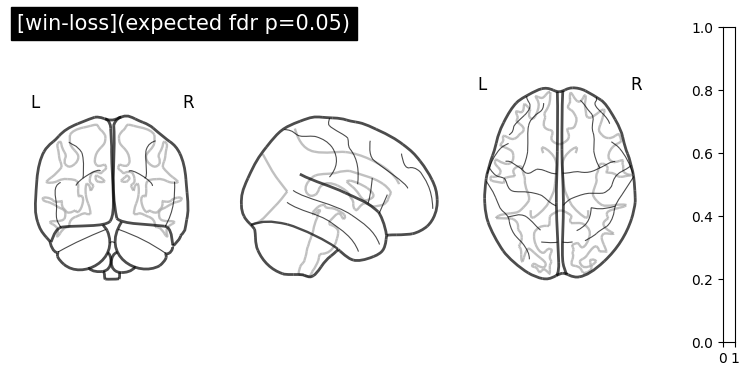

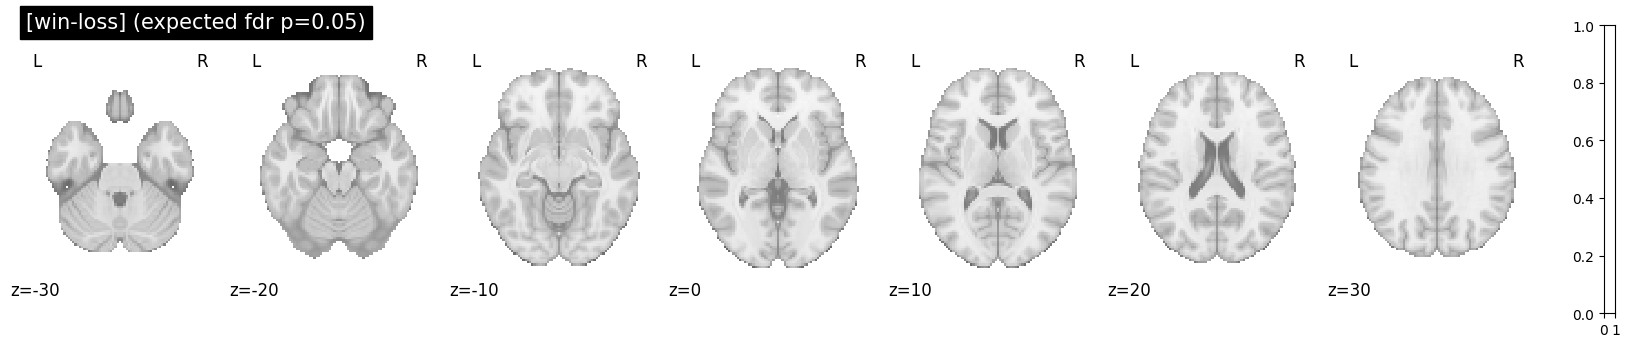

In [51]:
#Correct for multiple comparisons using FDR alpha = 0.05
thresholded_map2, threshold2 = threshold_stats_img(zmap_g, alpha=.05, height_control='fdr')
print(threshold2)
plotting.plot_glass_brain(thresholded_map2, cmap='viridis',colorbar=True, threshold=threshold2,
                          title='[win-loss](expected fdr p=0.05)', plot_abs=False)
plt.show()
plot_stat_map(thresholded_map2, cmap='viridis', threshold=threshold2, display_mode='z',  cut_coords=[-30,-20,-10,0,10,20,30],
black_bg=False, title='[win-loss] (expected fdr p=0.05)')
plt.show()